In [343]:
import torch  
import torch.nn as nn
from torch.optim import SGD, Adam
import numpy as np
import matplotlib.pyplot as plt
import time

"Using Cuda" if torch.cuda.is_available() else "Not using Cuda"

'Using Cuda'

In [344]:
def train_model(network : nn.Module, x, y, epochs=500, lr = 0.001, use_adam = False):
    f = network() 
    loss = nn.MSELoss()
    opt = Adam(f.parameters(), lr) if use_adam else SGD(f.parameters(), lr) # this step links the models's parameters to the optimizer


    # Train model
    losses = []
    for _ in range(epochs):
        opt.zero_grad() # flush previous epoch's gradient
        loss_value = loss(f(x), y) #compute loss
        loss_value.backward() # compute gradient
        opt.step() # Perform iteration using gradient above
        losses.append(loss_value.item())
    
    return f, losses

In [345]:
x = torch.tensor([[6,2],[5,2],[1,3],[7,6]]).float()
y = torch.tensor([1,5,2,5]).float()

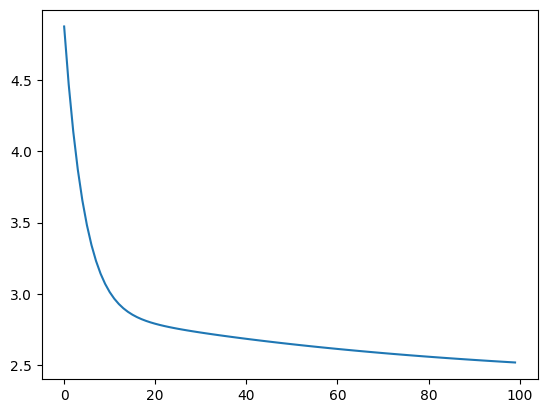

In [346]:
class BasicNetwork_24params(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2,8,bias=False)
        self.Matrix2 = nn.Linear(8,1,bias=False)

    def forward(self,x):
        x = self.Matrix1(x)
        x = self.Matrix2(x)
        return x.squeeze()
    
f, losses = train_model(BasicNetwork_24params, x, y, 100)
plt.plot(losses)
plt.show()

In [347]:
print(f"Final loss {losses[-1]}")
torch.dstack((f(x),y))  

Final loss 2.5169177055358887


tensor([[[3.1844, 1.0000],
         [2.7681, 5.0000],
         [1.4463, 2.0000],
         [4.9740, 5.0000]]], grad_fn=<CatBackward0>)

However you can see this model kinda sucks, this is because we really only actually have 2 independent parameters even though we have 24 parameters. 

This is because $M_1 \in \mathbb{R}^{2 \times 8}$ and $M_2 \in \mathbb{R}^{8 \times 1}$ and so $M_1 M_2 \in \mathbb{R}^{2 \times 1}$ and so there is effectively only 2 free parameters. So this complex matrix is actually collapsed into a small simple matrix. How do we fix this collapse?


Activation functions. So our model was like 
$$f_1(x) = M_2 M_1 x$$

Our new model with an activation function is 
$$f_2(x) = M_2 R(M_1 x)$$

where 
$$
R(x) = 
\begin{cases} 
x, & x \gt 0 \\ 
0, & x \leq 0
\end{cases}
$$

So R is the identity function if $x \gt 0$. Note this is obviously linear (cannot be encoded via a matrix). 

Now lets see how this changes our network

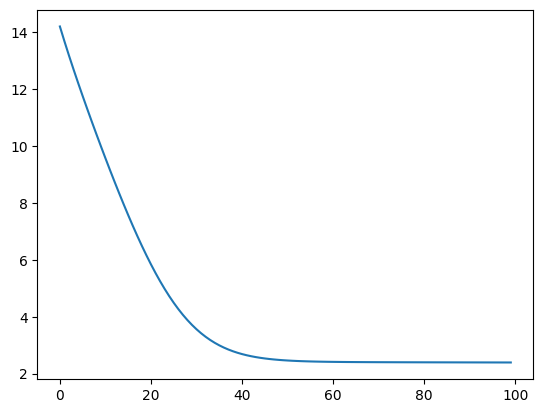

In [348]:
class ReluNetwork_24params(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2,8,bias=False)
        self.Matrix2 = nn.Linear(8,1,bias=False)
        self.R = nn.ReLU()

    def forward(self,x):
        x = self.R(self.Matrix1(x))
        x = self.Matrix2(x)
        return x.squeeze()

f, losses = train_model(ReluNetwork_24params, x, y, 100)
plt.plot(losses)
plt.show()

In [349]:
print(f"Final loss {losses[-1]}")
torch.dstack((f(x),y))

Final loss 2.389148712158203


tensor([[[2.9830, 1.0000],
         [2.6596, 5.0000],
         [1.6423, 2.0000],
         [5.1340, 5.0000]]], grad_fn=<CatBackward0>)

As you can see it's still pretty garbage, however overall it is an improvement. Now the real advantage of having a non-linear activation function is when we add more parameters as our neural network doesn't get compressed into a smaller matrix. 

Last model
$$ f_2(x) = M_2 R(M_1 x) \quad \text{ where } M_1 \in \mathbb{R}^{8 \times 2}, M_2 \in \mathbb{R}^{1 \times 8}$$

New Model
$$ f_3(x) = M_2 R(M_1 x) \quad \text{ where } M_1 \in \mathbb{R}^{80 \times 2}, M_2 \in \mathbb{R}^{1 \times 80}$$

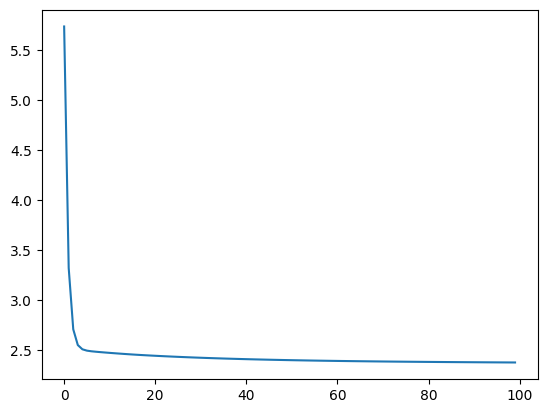

In [350]:
class ReluNetwork_240params(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2,80,bias=False)
        self.Matrix2 = nn.Linear(80,1,bias=False)
        self.R = nn.ReLU()

    def forward(self,x):
        x = self.R(self.Matrix1(x))
        x = self.Matrix2(x)
        return x.squeeze()

f, losses = train_model(ReluNetwork_240params, x, y, 100)
plt.plot(losses)
plt.show()

In [351]:
print(f"Final loss {losses[-1]}")
torch.dstack((f(x),y))

Final loss 2.3779921531677246


tensor([[[2.9104, 1.0000],
         [2.5816, 5.0000],
         [2.0139, 2.0000],
         [5.1130, 5.0000]]], grad_fn=<CatBackward0>)

So again marginally better but still quite garb-age as the french would say. So lets add a bias vector per each layer. 


Last Model
$$ f_3(x) = M_2 R(M_1 x) \quad \text{ where } M_1 \in \mathbb{R}^{80 \times 2}, M_2 \in \mathbb{R}^{1 \times 80}$$

New Model
$$ f_4(x) = M_2 R(M_1 x + b_1) + b_2 \quad \text{ where } M_1 \in \mathbb{R}^{80 \times 2}, M_2 \in \mathbb{R}^{1 \times 80}$$

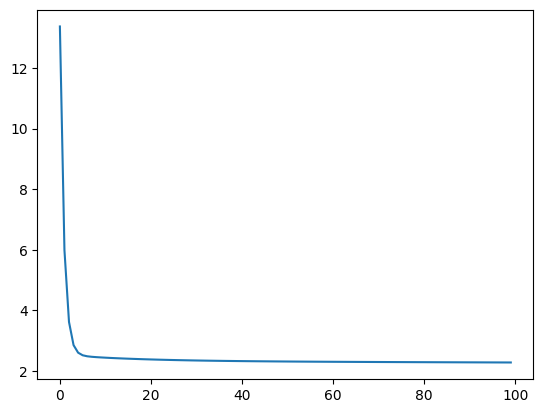

In [352]:
class ReluNetwork_240biased(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2,80)
        self.Matrix2 = nn.Linear(80,1)
        self.R = nn.ReLU()

    def forward(self,x):
        x = self.R(self.Matrix1(x))
        x = self.Matrix2(x)
        return x.squeeze()

f, losses = train_model(ReluNetwork_240biased, x, y, 100)
plt.plot(losses)
plt.show()

In [353]:
print(f"Final loss {losses[-1]}")
torch.dstack((f(x),y))

Final loss 2.2777884006500244


tensor([[[2.8678, 1.0000],
         [2.6322, 5.0000],
         [2.0307, 2.0000],
         [5.1133, 5.0000]]], grad_fn=<CatBackward0>)

So again better but still sadly, is very succ. Now we're going to add a matrix in the middle see what happens. 


Last Model
$$ f_4(x) = M_2 R(M_1 x + b_1) + b_2 \quad \text{ where } M_1 \in \mathbb{R}^{80 \times 2}, M_2 \in \mathbb{R}^{1 \times 80}$$

New Model
$$ f_4(x) = M_3R(M_2 R(M_1 x + b_1) + b_2) + b_3 \quad \text{ where } M_1 \in \mathbb{R}^{80 \times 2}, M_2 \in \mathbb{R}^{80 \times 80}, M_3 \in \mathbb{R}^{1 \times 80}$$

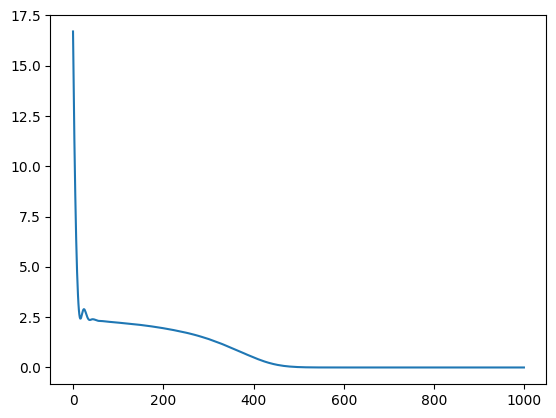

In [354]:
class ReluNetwork_6640biased(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2,80)
        self.Matrix2 = nn.Linear(80,80)
        self.Matrix3 = nn.Linear(80,1)
        self.R = nn.ReLU()

    def forward(self,x):
        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))
        x = self.Matrix3(x)
        return x.squeeze()

f, losses = train_model(ReluNetwork_6640biased, x, y, 1000, 0.001, True)
plt.plot(losses)
plt.show()

In [355]:
print(f"Final loss {losses[-1]}")
torch.dstack((f(x),y))

Final loss 5.151434834260726e-13


tensor([[[1.0000, 1.0000],
         [5.0000, 5.0000],
         [2.0000, 2.0000],
         [5.0000, 5.0000]]], grad_fn=<CatBackward0>)

In [356]:
# in our training data [5,2] -> 5 and [6,2] -> 1 hence you can see the model has learned to interpolate between these two
for d in range(11):
    print(f(torch.tensor([[5 + (1 / 10) * d,2]]).float()).item())


4.999998569488525
4.59999942779541
4.200000286102295
3.7999985218048096
3.3999993801116943
2.999999761581421
2.6000001430511475
2.2000010013580322
1.799999713897705
1.4000005722045898
1.000001072883606


## Sequential Network 
This is a general sequential neural network. 

$$f(x) = \circ^n_{i=1} R_i(A_i x + b_i)$$

Where $\circ$ is function composition so $(\circ^{n}_{i=1} f_i) x = f_1 \circ f_2 \circ \ldots \circ f_n(x) = f_1(f_2( \ldots f_n( x ) ) ) $

Where $A_i$ and $b_i$ are the matrices and basis vectors reactively and $R_i$ is the activation function for each layer. 